In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import pickle
import os

# Any results you write to the current directory are saved as output.

## CSE 258 Assignment 2

### 1. Get initial links to all products

In [2]:
import urllib.request
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import io
import bs4 as bs
from bs4 import SoupStrainer  # for parsing contents on webpage
import pandas as pd   
import codecs
from collections import defaultdict
import re
import math
import pickle

cate_link = [] # store links directing to different years
cate_list = ['lips','eye','cheek']

for i in cate_list:              
    cate_link.append('https://www.sephora.com/shop/' + i + "-makeup") # construct URL format
    
for link in cate_link:   
    print(link)

https://www.sephora.com/shop/lips-makeup
https://www.sephora.com/shop/eye-makeup
https://www.sephora.com/shop/cheek-makeup


### 2. Get productID and #review

### a) Pagelinks for each category

In [2]:
user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,} 

product_pagelink = defaultdict(list)
i = 0

for url in cate_link:
#    count = 0

    request=urllib.request.Request(url,None,headers) #The assembled request
    html = urllib.request.urlopen(request).read()
#print(html)

    soup = bs.BeautifulSoup(html, 'html5lib') 
    
    page_num = soup.find(lambda tag: tag.name =='span' and tag.has_attr('data-at') and tag['data-at'] == 'number_of_products')
    page_num = math.ceil(int(page_num.get_text().split()[0])/12)
    
    for page in range(page_num):
        product_pagelink[cate_list[i]].append(cate_link[i] + '?pageSize=12&currentPage=' + str(page+1))   
              
    i+=1
print("done")

done


### b) ProductID and Product link

In [6]:
id_link = {}
count = 0


product_pagelink = pickle.load(open('product_pagelink.p', 'rb'))
for url in product_pagelink['lips']:

    request=urllib.request.Request(url,None,headers) 
    html = urllib.request.urlopen(request).read()
    soup = bs.BeautifulSoup(html, 'html5lib')


    table = soup.find(lambda tag: tag.name=='div' and tag.has_attr('data-comp') and tag['data-comp']=="ProductGrid") 

    for doc in table.find_all('div')[1:]:
        try:
            doclink = doc.find_all(name='a')[0] 

#            if "product" in str(doclink.get("href")):
            p_id = doclink.get("href").split(':')[1]
            p_link1 = doclink.get("href").split()[0]
            p_link2 = doclink.get("href").split()[1]
            idlink = 'https://www.sephora.com' + p_link1 + p_link2
            id_link[p_id] = idlink
            count += 1

        except IndexError:
            continue

print("There're " + str(count) + " products added from lips make-up. ")


There're 626 products added from lips make-up. 


In [7]:
id_reviewnum = {}
import requests

for product in id_link:

    url = id_link[product]
    html = requests.get(url, {'User-Agent': 'Mozilla/5.0'}).text

    soup = bs.BeautifulSoup(html, 'html5lib')


    button = soup.find(lambda tag: tag.name=='button' and tag.has_attr('data-comp') and tag['data-comp']=="RatingsSummary Box") 
    
    review_num = button.find_all('span')[0].get_text()
    review_num = review_num.split()[0]
    
    if 'K' in review_num:
        review_num = int(review_num.replace("K","000"))
    else:
        review_num = int(review_num)
    
    id_reviewnum[product] = review_num

print('Done')

Done


In [49]:
list_of_reviews = []
import urllib.request, json
# id_reviewnum = pickle.load(open('id_reviewnum.p', 'rb'))
# api = ["https://api.bazaarvoice.com/data/reviews.json?Filter=ProductId%3A" + id + "&Sort=Helpfulness%3Adesc&Limit=100&Offset=" + count + "&Include=Products%2CComments&passkey=rwbw526r2e7spptqd2qzbkp7&apiversion=5.4"]
api = ["https://api.bazaarvoice.com/data/reviews.json?Filter=ProductId%3A", "&Sort=Helpfulness%3Adesc&Limit=100&Offset=", "&Include=Products%2CComments&passkey=rwbw526r2e7spptqd2qzbkp7&apiversion=5.4"]
for id in id_reviewnum:
    count = 0
    while count < id_reviewnum[id]:
        endpoint = api[0] + id + api[1] + str(count) + api[2]
#        print(endpoint)
        with urllib.request.urlopen(endpoint) as url:
            data = json.loads(url.read().decode())
            list_of_reviews.append(data)
        count += 100

pickle.dump(list_of_reviews, open('list_of_reviews.p', 'wb'))

After retreiving all review numbers for each product, we export the all the reviews(including user information) to a pickle file for further analysis. 

In [50]:
# user_item = defaultdict(list)
# user_cate = defaultdict(list)
# user_brand = defaultdict(list)
# item_cate = defaultdict(set)
# item_brand = defaultdict(set)
# item_review = defaultdict(list)


# list_of_reviews = pickle.load(open('list_of_reviews_new.p', 'rb'))
# product_id_map = defaultdict(list)
# user_id = defaultdict(list)

# #user_item_validation =  defaultdict()

# count = 0
 
# data = []
# for product in list_of_reviews:
    
#     item_id = None
#     cate_id = None
#     if 'Products' in product['Includes']:
#         count += len(product['Results'])
        
#         color_ids = list(product['Includes']['Products'].keys())
#         if len(product['Includes']['Products'][color_ids[0]]["FamilyIds"]) == 0:
#             product_id = color_ids[0]
#             category_id = product['Includes']['Products'][color_ids[0]]["CategoryId"]
#             item_cate[product_id].add(category_id)
#             product_id_map[product_id].append(1)
#             brand = product['Includes']['Products'][color_ids[0]]['Brand']['Name']
#             item_brand[product_id] = brand
#             item_review[product_id].append(len(product['Results']))
#         else:
#             product_id = product['Includes']['Products'][color_ids[0]]["FamilyIds"][0]
#             category_id = product['Includes']['Products'][color_ids[0]]["CategoryId"]
#             item_cate[product_id].add(category_id)
#             product_id_map[product_id].append(1)
# #            print(product['Includes']['Products'][color_ids[0]]['Brand']['Name'])
#             brand = product['Includes']['Products'][color_ids[0]]['Brand']['Name']
#             item_brand[product_id] = brand
#             item_review[product_id].append(len(product['Results']))
#     for result in product["Results"]:
        
#         entry = {
#             'review_text': result["ReviewText"],
#             "Helpfulness": result["Helpfulness"]
#         }
#         data.append(entry)
        
#         u_id = result['AuthorId']
#         user_id[u_id].append(1)
#         user_item[(u_id,product_id)].append(1)
#         user_cate[(u_id,category_id)].append(1)
#         user_brand[(u_id,brand)].append(1)
        
# print(str(count) + ' reviews retrieved.')


247901 reviews retrieved.


In [3]:
user_item = defaultdict(list)
user_cate = defaultdict(list)
user_brand = defaultdict(list)
item_cate = defaultdict(set)
item_brand = defaultdict(set)
item_review = defaultdict(list)


list_of_reviews = pickle.load(open('list_of_reviews.p', 'rb'))
product_id_map = defaultdict(list)
user_id = defaultdict(list)

#user_item_validation =  defaultdict()

count = 0
 
data = []
for product in list_of_reviews:
    
    item_id = None
    cate_id = None
    if 'Products' in product['Includes']:
        count += len(product['Results'])
        
        color_ids = list(product['Includes']['Products'].keys())
        if len(product['Includes']['Products'][color_ids[0]]["FamilyIds"]) == 0:
            product_id = color_ids[0]
            category_id = product['Includes']['Products'][color_ids[0]]["CategoryId"]
            item_cate[product_id].add(category_id)
            product_id_map[product_id].append(1)
            brand = product['Includes']['Products'][color_ids[0]]['Brand']['Name']
            item_brand[product_id] = brand
            item_review[product_id].append(len(product['Results']))
        else:
            product_id = product['Includes']['Products'][color_ids[0]]["FamilyIds"][0]
            category_id = product['Includes']['Products'][color_ids[0]]["CategoryId"]
            item_cate[product_id].add(category_id)
            product_id_map[product_id].append(1)
#            print(product['Includes']['Products'][color_ids[0]]['Brand']['Name'])
            brand = product['Includes']['Products'][color_ids[0]]['Brand']['Name']
            item_brand[product_id] = brand
            item_review[product_id].append(len(product['Results']))
    for result in product["Results"]:
        
        entry = {
            'review_text': result["ReviewText"],
            "Helpfulness": result["Helpfulness"]
        }
        data.append(entry)
        
        u_id = result['AuthorId']
        user_id[u_id].append(1)
        user_item[(u_id,product_id)].append(1)
        user_cate[(u_id,category_id)].append(1)
        user_brand[(u_id,brand)].append(1)
        
print(str(count) + ' reviews retrieved.')


252317 reviews retrieved.


defaultdict(list,
            {('5893067717', 'P393411'): [1],
             ('9467095118', 'P393411'): [1],
             ('2058214305', 'P393411'): [1],
             ('5261843836', 'P393411'): [1],
             ('6813872233', 'P393411'): [1],
             ('6058327097', 'P393411'): [1, 1],
             ('1714782145', 'P393411'): [1],
             ('5251050965', 'P393411'): [1],
             ('2387894810', 'P393411'): [1],
             ('6250891037', 'P393411'): [1],
             ('6543480579', 'P393411'): [1],
             ('1644380793', 'P393411'): [1],
             ('5513766446', 'P393411'): [1],
             ('8765909964', 'P393411'): [1],
             ('5794081029', 'P393411'): [1],
             ('1562552893', 'P393411'): [1],
             ('7463097047', 'P393411'): [1],
             ('1493464282', 'P393411'): [1],
             ('5373653361', 'P393411'): [1],
             ('5102142018', 'P393411'): [1],
             ('2281270687', 'P393411'): [1],
             ('7164948514', 'P3934

In [4]:
print(str(len(user_id)) + " users detected.")

175434 users detected.


So here we're looking at 252317 reviews from 175434 users about all lip make-up products on Sephora. 

Let's start with exploring analysis with our dataset.

### 3. EDA

In [5]:
item_review_sum = {}
for pro in item_review:
#     print(pro, item_review[pro], type(item_review[pro]))
    item_review_sum[pro] = sum(item_review[pro]) 
    
list1 = sorted(item_review_sum.values())
review_count = defaultdict(list)

for item in item_review_sum:
    num = item_review_sum[item]
    if num <= 200:
        review_count['0~200'].append(1)
    elif num <= 500 and num > 200:
        review_count['200~500'].append(1)
    elif num <= 1000 and num >500:
        review_count['500~1000'].append(1)
    elif num <= 2000 and num > 1000:
        review_count['1000~2000'].append(1)
    elif num <= 5000 and num > 2000:
        review_count['2000~5000'].append(1)
    else:
        review_count['>5000'].append(1)
        
# count_review = {}
count_review = []
# x_axis = []
for x in review_count:
    count_review.append((len(review_count[x]), x))
#     count_review[x] = len(review_count[x])
#     x_axis.append(x)
count_review.sort(reverse = True)


x_axis = []
y_axis = []
for entry in count_review:
    x_axis.append(entry[1])
    y_axis.append(entry[0])

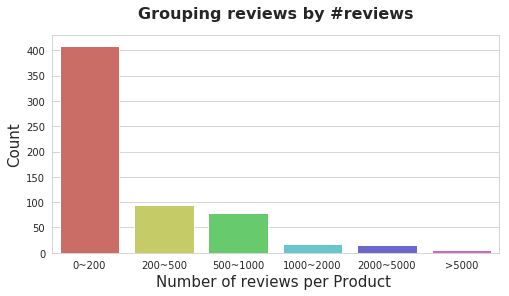

Average #reviews per product: 406.96290322580643
Median #reviews per product: 69
Max #reviews per product: 12700
Min #reviews per product: 1


In [6]:
plt.figure(figsize=(8,4))
sns.set_style("whitegrid")
plt.title('Grouping reviews by #reviews', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Number of reviews per Product ', fontsize=15)
plt.ylabel('Count', fontsize=15)
sns.barplot(x_axis, y_axis, palette="hls")
plt.show()

print("Average #reviews per product: " + str(count / len(item_cate)))
print("Median #reviews per product: " + str(list1[math.ceil(len(list1)/2)]))
print("Max #reviews per product: " + str(max(item_review_sum.values())))
print("Min #reviews per product: " + str(min(item_review_sum.values())))

In [126]:
user = defaultdict(list)
list_of_reviews = pickle.load(open('list_of_reviews.p', 'rb'))

for product in list_of_reviews:
    for result in product["Results"]:
        
        data.append(entry)
        
        u_id = result['AuthorId']
        user[u_id].append(1)

purchase_count = []

for u in user:
    num = len(user[u])
    purchase_count.append((num,u))
    
purchase_count.sort()
    
dic1 = defaultdict(list)

for pur in purchase_count:
    dic1[pur[0]].append(1)

x_axis = []
y_axis = []

for entry in dic1:
    x_axis.append(entry)
    y_axis.append(math.log(len(dic1[entry])))

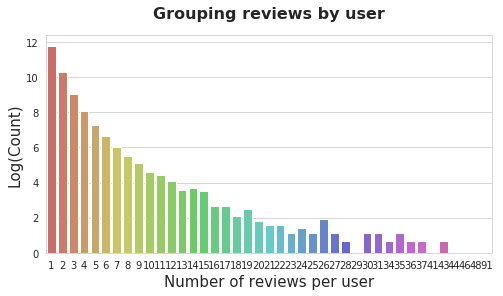

Average #reviews per user: 0.3217905309119099
Median #reviews per user: 1
Max #reviews per user: 91
Min #reviews per user: 1


In [127]:
f2 = plt.figure(figsize=(8,4))
sns.set_style("whitegrid")
plt.title('Grouping reviews by user', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Number of reviews per user', fontsize=15)
plt.ylabel('Log(Count)', fontsize=15)
sns.barplot(x_axis, y_axis, palette="hls")
plt.show()

print("Average #reviews per user: " + str(count / len(user)))
print("Median #reviews per user: " + str(purchase_count[math.ceil(len(purchase_count)/2)][0]))
print("Max #reviews per user: " + str(max(x_axis)))
print("Min #reviews per user: " + str(min(x_axis)))

f2.savefig('user_review.png')

### 4. Prediction

### Task I Recommend products to users

In [71]:
# Get popular items

mostPopular = [(item_review[x], x) for x in item_review]
mostPopular.sort()
mostPopular.reverse()

popuitem = set()
count = 0
for icount, i in mostPopular:
    count += 1
    popuitem.add(i)
    if count > 50: 
        break   

### Task II Predict usefulness of the review

[nltk_data] Downloading package punkt to /Users/roxi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/roxi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


In [248]:
print(len(train_x),len(train_y))

56453 56453


In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
train_transformed = vectorizer.fit_transform(train_x)   

dictionary = {
    'train_x': train_transformed,
    'train_y': train_y
}


In [395]:
length = []
score = []

for i in range(40291):
    a = len(train_x[i])
    b = train_y[i]
    if a < 2000 and b != 0:
        length.append(a)
        score.append(b)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


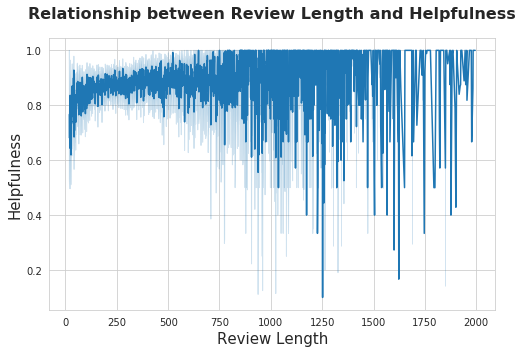

In [403]:
fi2 = plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
plt.title('Relationship between Review Length and Helpfulness', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Review Length', fontsize=15)
plt.ylabel('Helpfulness', fontsize=15)
sns.lineplot(length, score)
plt.show()
fi2.savefig('pic/review_length_helpfulness1.png')

In [412]:
len('waihg  wog')

10

In [411]:
df.to_csv("len_score.csv")

### Using TF-IDF

In [511]:
# train using linear regression
from sklearn.linear_model import LinearRegression
import pickle
dictionary = pickle.load(open('train_data.p', 'rb'))
train_transformed = dictionary['train_x']
train_y = dictionary['train_y']
reg = LinearRegression().fit(train_transformed, train_y)

# from sklearn.linear_model import LogisticRegression
# log = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(train_transformed, train_y)

# from sklearn.svm import SVC
# clf = SVC(gamma='auto', kernel="sigmoid")
# clf.fit(train_transformed, train_y) 

In [323]:
train_transformed

<56221x250 sparse matrix of type '<class 'numpy.float64'>'
	with 826635 stored elements in Compressed Sparse Row format>

In [324]:
print(len(train_x),len(train_y))

40291 56221


In [326]:
def mse(y_actual, y_predicted):
    total = 0.0
    count = 0
    for i in range(len(y_actual)):
        total += (y_actual[i] - y_predicted[i]) * (y_actual[i] - y_predicted[i])
        count += 1
    return total / count


baseline result:  0.1500289309435037
tf-idf result: 0.11521683929277132


In [484]:
import pickle
import random
threshold = 0.7
random.seed(17)
num_of_features = 500

vectorizer = pickle.load(open('tf_idf_model.p', 'rb'))

data = pickle.load(open('data.p', 'rb'))

validation_data = data[int(len(data) * threshold):]
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
test_x = []
test_y = []
#baseline_y = []


for entry in validation_data:
    if entry['Helpfulness'] != None:
        process_sent = ""
        tokens = word_tokenize(entry['review_text'])
        for word in tokens:
            process_sent += lemmatizer.lemmatize(word) + " "
        process_sent = process_sent.strip()
        test_x.append(process_sent)
        test_y.append(entry['Helpfulness'])




In [506]:
len(test_y)

18621

In [481]:
lam_list = []
result_base = []
result_reg1 = []

In [518]:
l_list = [7,8]
lam_list = []
result = []

tf_test = vectorizer.transform(val_x)

for lam in l_list:
    print(lam)
    lam_list.append(lam)
    predicted_y1 = []
    for i in range(9311):
            
        predict_lr = reg2.predict(tf_test[i])
#        print(predict_lr[0])
        regr = - lam * (10**-5) * df_document_topic_val.iloc[i,16]
#        print(reg)
        predicted_y1.append(predict_lr-regr)
    
    res = mse(val_y, predicted_y1)
    
    result.append(res[0])
    print('TF-IDF result:', res)

7


ValueError: dimension mismatch

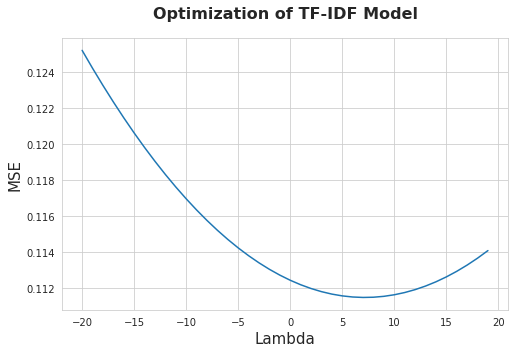

In [514]:
fi5 = plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
plt.title('Optimization of TF-IDF Model', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('MSE', fontsize=15)
sns.lineplot(lam_list, result)
plt.show()


fi5.savefig('pic/reg1_optimization.png')

### Using LDA

In [328]:
import random
import pickle
threshold = 0.5
random.seed(17)
num_of_features = 500
data = pickle.load(open('data.p', 'rb'))
random.shuffle(data)
train_data = data[:int(len(data) * threshold)]



     
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

count = 0
train_x = []
train_y = []
for record in train_data:
    if record['Helpfulness'] != None:
        tokens = word_tokenize(record['review_text'])
        process_sent = ""
        for word in tokens:
            process_sent += lemmatizer.lemmatize(word) + " "
        process_sent = process_sent.strip()
        train_x.append(process_sent)
        train_y.append(record['Helpfulness'])
        if count % 5000 == 0:
            print(count)
        count += 1

[nltk_data] Downloading package punkt to /Users/roxi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/roxi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0
5000
10000
15000
20000
25000
30000
35000
40000


In [329]:
print(len(train_x),len(train_y))

40291 40291


In [494]:
print(len(test_x),len(test_y))

27932 27932


In [495]:
val_x = test_x[:math.ceil(len(test_x)/3)]
val_y = test_y[:math.ceil(len(test_y)/3)]

test_x = test_x[math.ceil(len(test_x)/3):]
test_y = test_y[math.ceil(len(test_y)/3):]

In [496]:
print(len(val_x),len(val_y))
print(len(test_x),len(test_y))

9311 9311
18621 18621


In [353]:
no_features = 1000

#tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(train_x)
tf_feature_names = tf_vectorizer.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic" + str(topic_idx) + ":")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [360]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
from collections import defaultdict

dict1= defaultdict(list)

tf_val = tf_vectorizer.transform(test_x)

for topic in range(15,25,1):
    print(topic)
    no_topics = topic
    dict1['#topic'].append(topic)

    lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
    train_output = lda_model.transform(tf)
    dict1['model_loglikelihood'].append(lda_model.score(tf))
    dict1['model_perplexity'].append(lda_model.perplexity(tf))

    reg2 = LinearRegression().fit(tf, train_y)

#topic_probability_scores = lda_model.transform(tf_val)


    prediction = reg2.predict(tf_val)
    msescore =  mse(test_y, prediction)
    dict1['MSE'].append(msescore) 

# Run NMF
#nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA


15
16
17
18
19
20
21
22
23
24


In [361]:
dict1

defaultdict(list,
            {'#topic': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
             'MSE': [0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403,
              0.11087304777457403],
             'model_loglikelihood': [-5839527.734060916,
              -5862523.743103024,
              -5871409.85324313,
              -5871373.935690109,
              -5874825.186300991,
              -5891637.942804745,
              -5912014.697301019,
              -5911136.048998294,
              -5918781.156411581,
              -5936159.312419161],
             'model_perplexity': [423.2268901699496,
              433.42771242741054,
              437.43504911060467,
              437.4187771560674,
              438.9850874537416,
         

### Final Model

In [375]:
 lda_model = LatentDirichletAllocation(n_components=15, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)    

In [376]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tf))

# See model parameters
print(lda_model.get_params())

#lda_output = lda_model.transform(tf)
reg2 = LinearRegression().fit(tf, train_y)
predic_train = reg2.predict(tf)

print('MSE on training:', mse(train_y, predic_train))

Log Likelihood:  -5839527.734060916
Perplexity:  423.2268901699496
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 15, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}
MSE on training: 0.1219117761902836


In [365]:

no_top_words = 10
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda_model, tf_feature_names, no_top_words)

Topic0:
pencil touch lasted ago box month incredibly wore play drugstore
Topic1:
love colour lip absolutely power staying color look doe beautiful
Topic2:
product price worth size packaging great high totally scrub good
Topic3:
lipstick color formula liquid shade dry like drying doe transfer
Topic4:
wa sephora try store did color went bought tried looked
Topic5:
gloss lip sticky color love like just look shine glossy
Topic6:
review brand wish sephora cute kat soon von does better
Topic7:
lip product use dry balm day like time using work
Topic8:
result started difference slight bag scent tiny excellent start flavor
Topic9:
color look pink skin natural lip love tone light great
Topic10:
wa did product star really disappointed like color thought excited
Topic11:
shade nude perfect lipstick color ve favorite best great new
Topic12:
liner received lip eating stay drinking color product sample free
Topic13:
lipstick matte lip wear dry red stain color drying long
Topic14:
lip balm love produc

In [377]:
lda_output = lda_model.transform(tf)

# index names
docnames = ["Reviewi" + str(i) for i in range(len(train_x))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['helpfulness'] = train_y

# Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
#df_document_style = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
#df_document_style

In [372]:
lda_output

array([[0.02197304, 0.0019614 , 0.0019611 , ..., 0.48947839, 0.00196107,
        0.00196111],
       [0.00166672, 0.00166704, 0.21973828, ..., 0.13000609, 0.00166681,
        0.00166693],
       [0.02500432, 0.02500748, 0.025004  , ..., 0.28850457, 0.02500141,
        0.02501022],
       ...,
       [0.00263235, 0.20249704, 0.04288847, ..., 0.00263188, 0.00263284,
        0.08808269],
       [0.08341099, 0.00158759, 0.05493868, ..., 0.00158812, 0.19626304,
        0.00158762],
       [0.02949348, 0.0025009 , 0.00250067, ..., 0.00250091, 0.03069291,
        0.3593207 ]])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


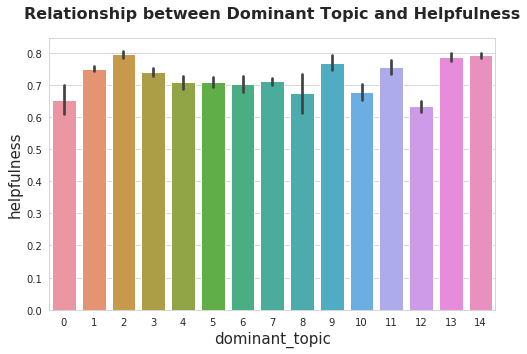

In [520]:
x_axis = df_document_topic.loc[:,'dominant_topic']
y_axis = df_document_topic.loc[:,'helpfulness']

fi1 = plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
plt.title('Relationship between Dominant Topic and Helpfulness', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Topic Index', fontsize=15)
plt.ylabel('Helpfulness', fontsize=15)
sns.barplot(x_axis, y_axis)
plt.show()

fi1.savefig('pic/topic_helpfulness2.png')

In [509]:
len(df_document_topic_test)

18621

### Predictions

In [508]:

# Step 3: Vectorize transform
tf_test = tf_vectorizer.transform(test_x)
rv_len = [len(x) for x in test_x]
# Step 4: LDA Transform
topic_probability_scores = lda_model.transform(tf_test)

docnames = ["Review" + str(i) for i in range(len(test_x))]
df_document_topic_test = pd.DataFrame(np.round(topic_probability_scores, 2), index=docnames)
df_document_topic_test['helpfulness'] = test_y
df_document_topic_test['rev_len'] = rv_len
df_document_topic_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,helpfulness,rev_len
Review0,0.10,0.37,0.00,0.00,0.00,0.20,0.10,0.12,0.00,0.00,0.00,0.03,0.00,0.00,0.06,1.0,454
Review1,0.01,0.49,0.01,0.22,0.01,0.01,0.01,0.01,0.10,0.01,0.01,0.01,0.01,0.13,0.01,1.0,157
Review2,0.00,0.31,0.00,0.00,0.24,0.00,0.06,0.16,0.06,0.15,0.00,0.00,0.00,0.00,0.00,1.0,211
Review3,0.00,0.47,0.00,0.10,0.07,0.00,0.15,0.00,0.00,0.00,0.00,0.11,0.00,0.07,0.00,1.0,309
Review4,0.01,0.01,0.88,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,1.0,80


In [499]:

# Step 3: Vectorize transform
tf_val = tf_vectorizer.transform(val_x)
rv_len = [len(x) for x in val_x]
# Step 4: LDA Transform
topic_probability_scores = lda_model.transform(tf_val)

docnames = ["Review" + str(i) for i in range(len(val_x))]
df_document_topic_val = pd.DataFrame(np.round(topic_probability_scores, 2), index=docnames)
df_document_topic_val['helpfulness'] = val_y
df_document_topic_val['rev_len'] = rv_len
df_document_topic_val.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,helpfulness,rev_len
Review0,0.05,0.00,0.00,0.13,0.00,0.00,0.07,0.00,0.12,0.21,0.00,0.16,0.10,0.00,0.14,1.0,540
Review1,0.23,0.00,0.00,0.00,0.12,0.00,0.00,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.14,1.0,223
Review2,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.12,0.00,0.19,0.29,0.19,0.00,1.0,286
Review3,0.04,0.26,0.15,0.00,0.00,0.06,0.00,0.20,0.00,0.00,0.00,0.00,0.13,0.00,0.14,1.0,661
Review4,0.00,0.44,0.00,0.00,0.00,0.05,0.00,0.23,0.00,0.00,0.15,0.00,0.00,0.00,0.11,1.0,383


In [504]:
tf_val

<9311x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 181754 stored elements in Compressed Sparse Row format>

In [503]:
reg2.predict(tf_val[16])

array([0.76480848])

In [501]:
df_document_topic_val.iloc[0,16]

540

In [505]:
l_list = range(-20,20)
lam_list = []
result = []

for lam in l_list:
    print(lam)
    lam_list.append(lam)
    predicted_y2 = []
    for i in range(9311):
#        print(i)
        predict_lr = reg2.predict(tf_val[i])
#        print(predict_lr[0])
        reg = - lam * (10**-5) * df_document_topic_val.iloc[i,16]
#        print(reg)
        predicted_y2.append(predict_lr-reg)
    
    res = mse(val_y, predicted_y2)
    
    result.append(res[0])
    print('LDA result:', res)

-20
LDA result: [0.12782335]
-19
LDA result: [0.12707059]
-18
LDA result: [0.12635221]
-17
LDA result: [0.12566821]
-16
LDA result: [0.12501858]
-15
LDA result: [0.12440333]
-14
LDA result: [0.12382245]
-13
LDA result: [0.12327595]
-12
LDA result: [0.12276383]
-11
LDA result: [0.12228608]
-10
LDA result: [0.12184271]
-9
LDA result: [0.12143371]
-8
LDA result: [0.12105909]
-7
LDA result: [0.12071885]
-6
LDA result: [0.12041298]
-5
LDA result: [0.12014148]
-4
LDA result: [0.11990437]
-3
LDA result: [0.11970163]
-2
LDA result: [0.11953326]
-1
LDA result: [0.11939927]
0
LDA result: [0.11929966]
1
LDA result: [0.11923442]
2
LDA result: [0.11920356]
3
LDA result: [0.11920708]
4
LDA result: [0.11924497]
5
LDA result: [0.11931724]
6
LDA result: [0.11942388]
7
LDA result: [0.1195649]
8
LDA result: [0.11974029]
9
LDA result: [0.11995006]
10
LDA result: [0.12019421]
11


KeyboardInterrupt: 

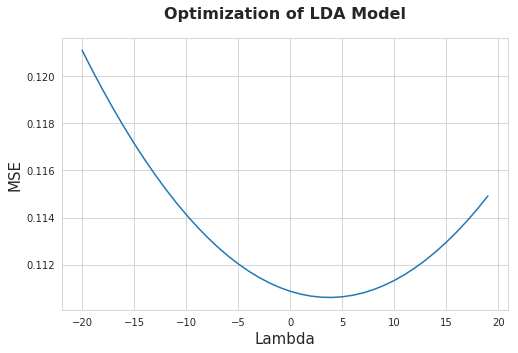

In [479]:
fi4 = plt.figure(figsize=(8,5))
sns.set_style("whitegrid")
plt.title('Optimization of LDA Model', fontsize=16, fontweight='bold', y=1.05,)
plt.xlabel('Lambda', fontsize=15)
plt.ylabel('MSE', fontsize=15)
sns.lineplot(lam_list, result)
plt.show()


fi4.savefig('pic/reg2_optimization.png')

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [10, 15, 20]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)



GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


In [74]:
import pickle
import random
threshold = 0.7
random.seed(17)
#num_of_features = 500

vectorizer = pickle.load(open('tf_idf_model.p', 'rb'))

data = pickle.load(open('data.p', 'rb'))

validation_data = data[int(len(data) * threshold):]
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
test_x = []
test_y = []
baseline_y = []

for entry in validation_data:
    if entry['Helpfulness'] != None:
        process_sent = ""
        tokens = word_tokenize(entry['review_text'])
        for word in tokens:
            process_sent += lemmatizer.lemmatize(word) + " "
        process_sent = process_sent.strip()
        test_x.append(process_sent)
        test_y.append(entry['Helpfulness'])
        
        baseline_score = min(1, len(entry['review_text']) * 0.001)
        baseline_y.append(baseline_score)

# transformed_x = vectorizer.transform(test_x)


# predicted_y = reg.predict(transformed_x)
# # predicted_y = clf.predict(transformed_x)
# #calculate mse







In [75]:
test_x = tf_vectorizer.transform(test_x)
lda_model = lda.fit(tf)
test_x = lda_model.transform(test_x) #learning the projection matrix


In [385]:
fifa = pd.read_csv('fifa_dataset.csv')